# Chapter 4d: ANN for seismic waveform analysis

In the final notebook of chapter 4 on feedforward neural networks, we will explore for the first time seismic waveform time series. We will spend a lot of time on this dataset as we will also use it in future chapters.

We will use the data provided in Mousavi et al. (2019) called _STanford EArthquake Dataset (STEAD)_. In a first step, we will build our $(X, y)$ data for model training. Then, in a second step, we will apply some ANN models to detect earthquakes. Recall that in the present chapter, we only consider dense, feedforward neural networks. We will use Keras (in Tensorflow 2) to build the model architecture. We will reproduce examples from early 1990‘s articles, from Dowla et al. (1990) and Wang & Teng (1995), which are some important early works on ANN applications to seismic waveform data. We will only consider earthquake discrimination in this chapter: Given a seismic waveform, has an earthquake occurred? We will look at P-wave picking in the next chapter.

<img src="figs_notebook/ref_Mousavi.png" width = 700>


## 1. Load, filter & visualize STEAD dataset

The _STanford EArthquake Dataset_ (STEAD) is a global dataset of seismic signals for AI. It is a high-quality, large-scale, and global data set of local earthquake and non-earthquake signals recorded by seismic instruments. The dataset in its current state contains two categories: (1) local earthquake waveforms (recorded at 'local' distances within 350 km of earthquakes) and (2) seismic noise waveforms that are free of earthquake signals. Together these data comprise ~ 1.2 million time series or more than 19,000 hours of seismic signal recordings. The dataset facilitates training, validation, and performance comparisons.

The seismic data are defined as individual NumPy arrays containing 3 1-minute-long waveforms for each of the 3 ground motion components (east-west, north-south, and vertical directions respectively). All seismograms (earthquake and non-earthquake) are resampled to 100 Hz, meaning 6000 samples for a 60-second duration (where the time of first sample is given by `trace_start_time` in UTC). The category of each seismogram (`trace_category`) and its name (`trace_name`) are given in the data attributes. The `trace_name` is a unique name containing station, network, recording time, and category code (`'EV'` for earthquake and `'NO'` for noise data). The sample points where P and S phases arrive (`p_arrival_sample` and `s_arrival_sample`) are provided while status (`p_status` and `s_status`) shows how these arrival times have been determined.

The data set contains seismograms associated with a wide range of earthquake sizes from magnitude −0.5 to magnitude 7.9, but small earthquakes (magnitudes < 2.5) comprise the majority of the data set.

Before we can start, you must download STEAD on your computer and define the folder `data/STEAD/` where the notebook is located. **WARNING:** the folder size will be just below 100 GB (200 GB if including both data chunks and final merged data). Go to https://github.com/smousavi05/STEAD#You_can_get_the_wavefoms_from_here and download STEAD. There are two options:

-  Download directly the full dataset in 2 files `merged.csv` and `merged.hdf5`: https://mega.nz/folder/HNwm0SLY#h70tuXK2tpiQJAaPq72FFQ
-  If your internet connection does not allow it, download all data in chunks (`chunk1.xxx`, ...) from the GitHub repository and then merge all chunks by using the notebook `merge.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plt_col

import h5py
import glob
import csv

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

Let us first load the data. Notice that we only consider a subset of the available seismic waveforms.

In [2]:
## modified from https://github.com/smousavi05/STEAD ##
file_name = "data/STEAD/merged.hdf5"
csv_file = "data/STEAD/merged.csv"

# reading the csv file into a dataframe:
df = pd.read_csv(csv_file)
print(f'total events in csv file: {len(df)}')
# filterering the dataframe
df_EQ = df[(df.trace_category == 'earthquake_local') & (df.source_distance_km <= 20) & (df.source_magnitude > 3)]
df_noise = df[(df.trace_category == 'noise') & (df.receiver_code == 'PHOB') ]
print(f'total earthquake time series selected: {len(df_EQ)}')
print(f'total noise time series selected: {len(df_noise)}')

# making a list of trace names for the selected data
EQ_list = df_EQ['trace_name'].to_list()
noise_list = df_noise['trace_name'].to_list()[:200]

/Users/arnaudmignan/miniforge3/envs/env_tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7,11,13,14,15,18,19,20,21,22,24,25,26,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


total events in csv file: 1265657
total earthquake time series selected: 2278
total noise time series selected: 468


### 1.1. Example of seismic waveform with arrival times

There are 35 attributes (labels) for each earthquake associated with each NumPy array. In addition to the station information (e.g. network code, code, type, and location of the receiver), information about the earthquake includes: origin time, epicentral location, depth, magnitude, magnitude type, focal mechanism, arrival times of P and S phases, estimated errors, etc., and recorded signal (e.g. measurement of the signal-to-noise ratio for each component, the end of signal’s dominant energy (coda-end), and epicentral distance). The unit of each attribute is included in the attribute’s name. Each window contains both P and S waves and begins from 5 to 10 seconds prior to the P arrival and ends at least 5 second after the S arrival.

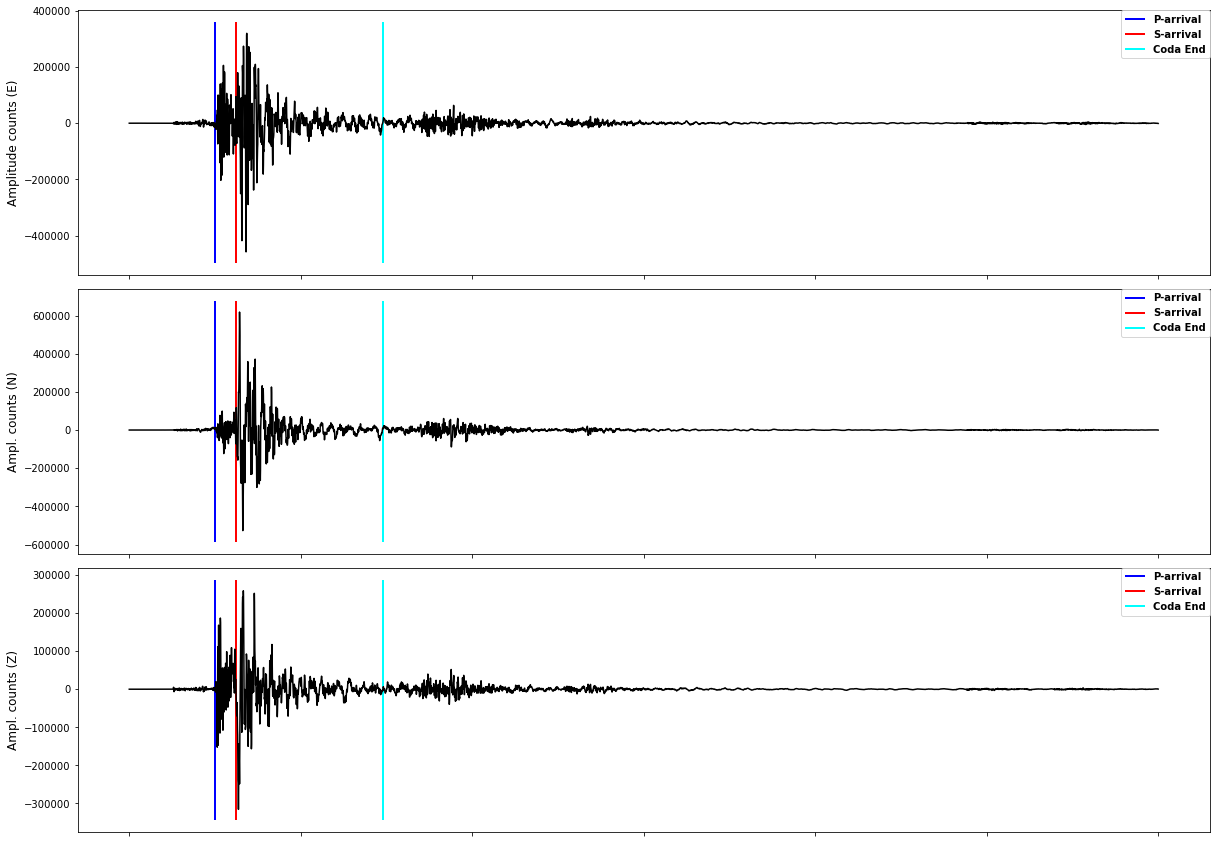

In [4]:
## from https://github.com/smousavi05/STEAD ##

# retrieving selected waveforms from the hdf5 file: 
evi = EQ_list[0]
dtfl = h5py.File(file_name, 'r')
dataset = dtfl.get('data/' + str(evi)) 

# waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
data = np.array(dataset)

fig = plt.figure()
ax = fig.add_subplot(311)         
plt.plot(data[:,0], 'k')
plt.rcParams["figure.figsize"] = (17, 12)
legend_properties = {'weight':'bold'}    
plt.tight_layout()
ymin, ymax = ax.get_ylim()
pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
plt.ylabel('Amplitude counts (E)', fontsize=12) 
ax.set_xticklabels([])

ax = fig.add_subplot(312)         
plt.plot(data[:,1], 'k')
plt.rcParams["figure.figsize"] = (17, 12)
legend_properties = {'weight':'bold'}    
plt.tight_layout()
ymin, ymax = ax.get_ylim()
pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
plt.ylabel('Ampl. counts (N)', fontsize=12) 
ax.set_xticklabels([])
    
ax = fig.add_subplot(313)         
plt.plot(data[:,2], 'k')
plt.rcParams["figure.figsize"] = (17, 12)
legend_properties = {'weight':'bold'}    
plt.tight_layout()
ymin, ymax = ax.get_ylim()
pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
plt.ylabel('Ampl. counts (Z)', fontsize=12) 
ax.set_xticklabels([])
plt.show() 

### 1.2. Example of seismic noise

One-minute noise waveforms provided in STEAD were randomly selected from the time periods between the cataloged earthquakes. There are 8 attributes for each noise seismogram. Noise attributes are mainly limited to the information about the recording instrument (e.g. network code, code, type, and location of the reciever).

An example of noise waveforms is given below:

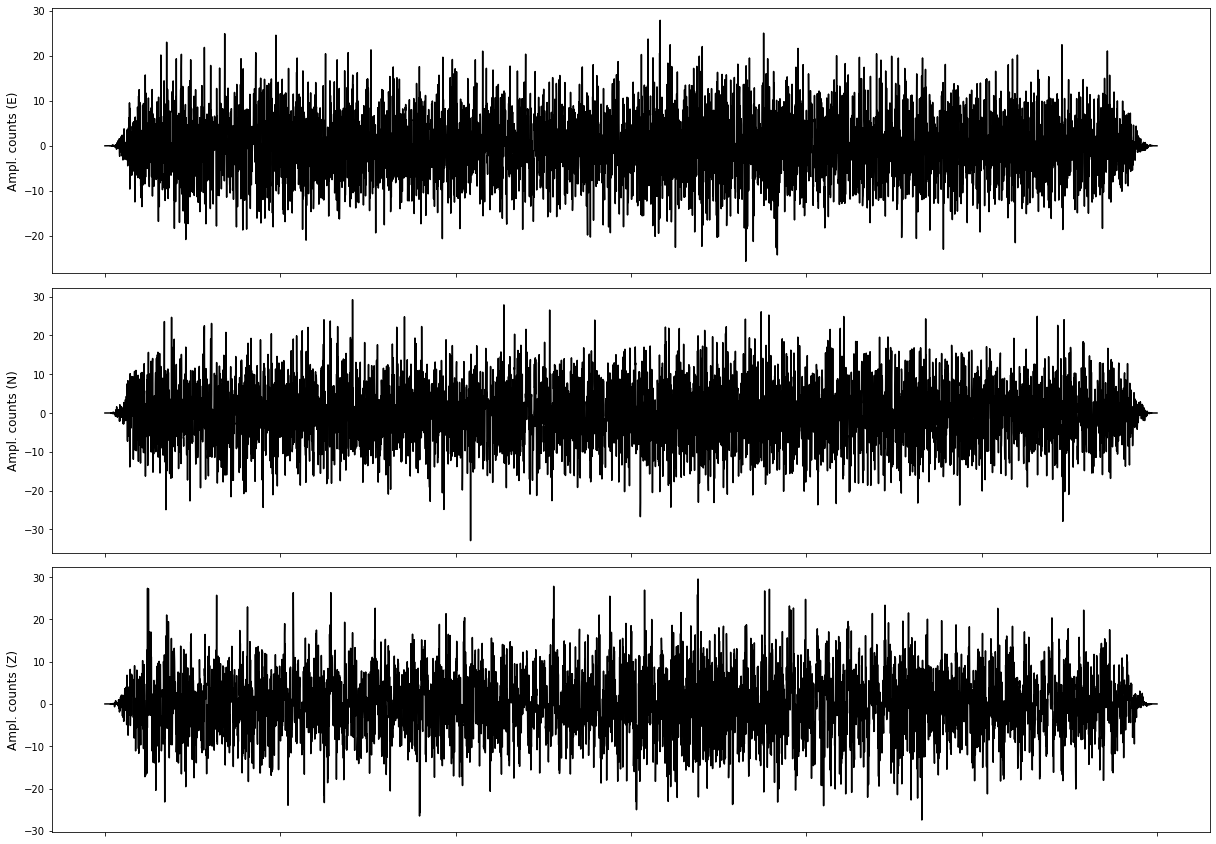

In [5]:
# retrieving selected waveforms from the hdf5 file: 
evi = noise_list[0]
dtfl = h5py.File(file_name, 'r')
dataset = dtfl.get('data/' + str(evi)) 

# waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
data = np.array(dataset)

fig = plt.figure()
ax = fig.add_subplot(311)         
plt.plot(data[:,0], 'k')
plt.rcParams["figure.figsize"] = (8, 5)
legend_properties = {'weight':'bold'}    
plt.tight_layout()
plt.ylabel('Ampl. counts (E)', fontsize=12) 
ax.set_xticklabels([])

ax = fig.add_subplot(312)         
plt.plot(data[:,1], 'k')
plt.rcParams["figure.figsize"] = (8, 5)
legend_properties = {'weight':'bold'}    
plt.tight_layout()     
plt.ylabel('Ampl. counts (N)', fontsize=12) 
ax.set_xticklabels([])

ax = fig.add_subplot(313)         
plt.plot(data[:,2], 'k')
plt.rcParams["figure.figsize"] = (8,5)
legend_properties = {'weight':'bold'}    
plt.tight_layout()     
plt.ylabel('Ampl. counts (Z)', fontsize=12) 
ax.set_xticklabels([])
plt.show()

## 2. Baseline model: STA-LTA

The simple __ratio of Short-Term-Average to Long-Term-Average (STA/LTA)__ filter is a popular and simple way to detect transient seismic events (Allen, 1982). The algorithm continuously calculates the average values of the absolute amplitude of a seismic signal in two consecutive moving-time windows. The short time window (STA) is sensitive to seismic events while the long time window (LTA) provides information about the temporal amplitude of seismic noise at the site. When the ratio of both exceeds a pre-set value, an event is 'declared'.

In [6]:
## function from https://github.com/obspy/obspy/blob/master/obspy/signal/trigger.py ##

def recursive_sta_lta_py(a, nsta, nlta):
    """
    Recursive STA/LTA written in Python.
    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of recursive STA/LTA
    .. seealso:: [Withers1998]_ (p. 98) and [Trnkoczy2012]_
    """
    try:
        a = a.tolist()
    except Exception:
        pass
    ndat = len(a)
    # compute the short time average (STA) and long time average (LTA)
    # given by Evans and Allen
    csta = 1. / nsta
    clta = 1. / nlta
    sta = 0.
    lta = 1e-99  # avoid zero division
    charfct = [0.0] * len(a)
    icsta = 1 - csta
    iclta = 1 - clta
    for i in range(1, ndat):
        sq = a[i] ** 2
        sta = csta * sq + icsta * sta
        lta = clta * sq + iclta * lta
        charfct[i] = sta / lta
        if i < nlta:
            charfct[i] = 0.
    return np.array(charfct)

**EXERCISE 1:** Use the function defined above to predict the earthquake arrival time of the first earthquake in our list. Plot the results. _Hint:_ The length of short time average window and long time average window can be defined as multiples of the sampling rate of the data. Consider using twice the sampling rate and 5 times the sampling rate, respectively.

Labelled P arrival: 500.0
Predicted by STA/LTA with threshold = 2: [500]


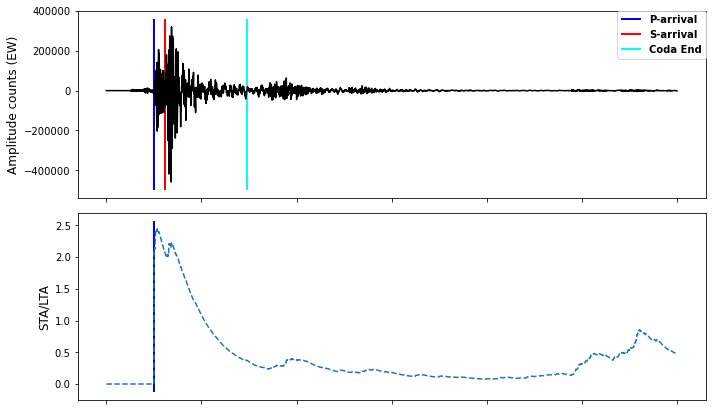

In [14]:
sampling_rate = 100    # Hz
threshold = 1.5        # fix to 1.5 for first run

evi = EQ_list[0]
dtfl = h5py.File(file_name, 'r')
dataset = dtfl.get('data/' + str(evi)) 
data = np.array(dataset)

# apply to one channel of seismometer output
#YOUR CODE HERE
#STALTA = ?
#P_pred = ?


#SOLUTION
STALTA = recursive_sta_lta_py(data[:,0], 2 * sampling_rate, 5 * sampling_rate)
P_pred = np.argwhere(STALTA > threshold)[0]



fig = plt.figure()
ax = fig.add_subplot(211)         
plt.plot(data[:,0], 'k')
plt.rcParams["figure.figsize"] = (10, 6)
legend_properties = {'weight':'bold'}    
plt.tight_layout()
ymin, ymax = ax.get_ylim()
pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
plt.ylabel('Amplitude counts (EW)', fontsize=12) 
ax.set_xticklabels([])

ax = fig.add_subplot(212)
#YOUR CODE HERE
#plt.plot(...)
#...


#SOLUTION
plt.plot(STALTA, '--')
plt.rcParams["figure.figsize"] = (10, 6)
legend_properties = {'weight':'bold'}    
plt.tight_layout()
ymin, ymax = ax.get_ylim()
pl = plt.vlines(P_pred, ymin, ymax, color='b', linewidth=2, label='P-arrival')
plt.ylabel('STA/LTA', fontsize = 12) 
ax.set_xticklabels([]);




print('Labelled P arrival:', dataset.attrs['p_arrival_sample'])
print('Predicted by STA/LTA with threshold = 2:', P_pred)

**EXERCISE 2:** Test this baseline model on the full earthquake list. Compare the observed P arrival `y_obs` to the one predicted `y_pred` by the STA/LTA model and compute the mean absolute error using `mae(y_obs, y_pred)`. We could then compare this result to P-wave picking neural network models in the next chapter.

In [15]:
#YOUR CODE HERE (multiple lines of code)


#SOLUTION
n = len(EQ_list)

y_obs = np.empty(shape = (n, 1))
y_pred = np.empty(shape = (n, 1))
for i in range(n):
    evi = EQ_list[i]
    dtfl = h5py.File(file_name, 'r')
    dataset = dtfl.get('data/' + str(evi)) 

    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
    data = np.array(dataset)
    
    y_obs[i] = dataset.attrs['p_arrival_sample']
    
    STALTA = recursive_sta_lta_py(data[:,0], 2 * sampling_rate, 5 * sampling_rate)
    ind = np.argwhere(STALTA > threshold)
    if len(ind) != 0:
        y_pred[i] = ind[0]

print('Mean absolute error:', mae(y_obs, y_pred))

Mean absolute error: 124.74275680421422


**EXERCISE 3:** Plot the results on a subset of 9 earthquake waveform time series. We first give you a template where you just have to add the vertical lines showing `y_obs` in green and `y_pred` in red. Then in a next cell, plot the matching STA/LTA curves.

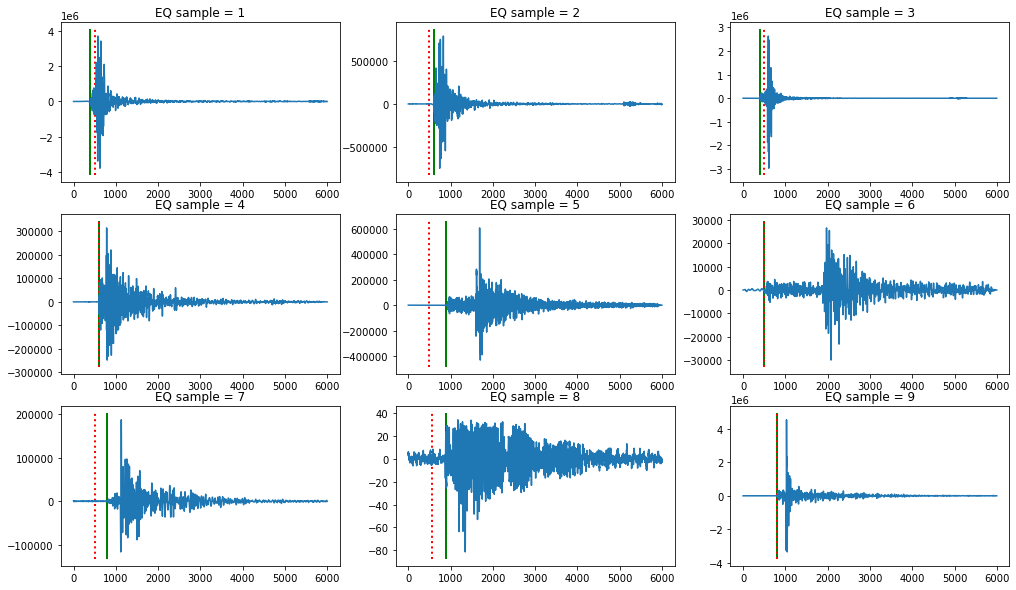

In [10]:
# plot some examples of seismic waveforms with y_obs and y_pred overlaid
nrow = 3
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(17, 10))
k = 0
for i in range(nrow):
    for j in range(ncol):
        k = k+1
        evi = EQ_list[k]
        dtfl = h5py.File(file_name, 'r')
        dataset = dtfl.get('data/' + str(evi)) 
        # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
        data = np.array(dataset)

        ax[i,j].plot(data[:,0])
        ymin, ymax = ax[i,j].get_ylim()
        
        #YOUR CODE HERE (=2 lines of code)
        
        
        #SOLUTION
        ax[i,j].vlines(y_obs[k], ymin, ymax, color='g', linewidth=2, label='y obs')
        ax[i,j].vlines(y_pred[k], ymin, ymax, color='r', linewidth=2, linestyle='dotted', label='y pred')
        
        
        ax[i,j].set_title('EQ sample = {0}'.format(k))

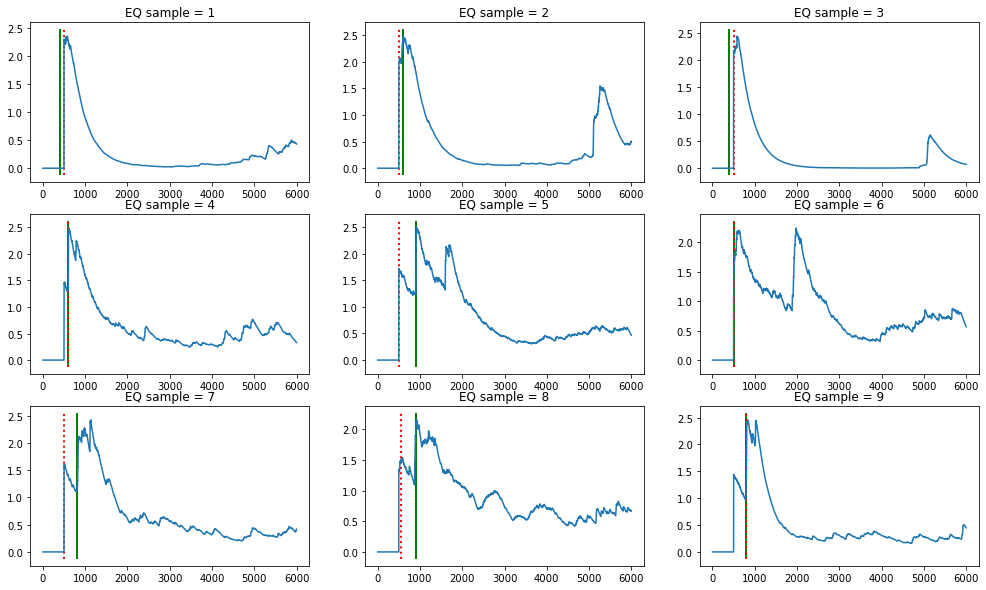

In [11]:
# plot some examples of STA/LTA time series with y_obs and y_pred overlaid
#YOUR CODE HERE (multiple lines of code)



#SOLUTION
n = len(EQ_list)

y_obs = np.empty(shape = (n, 1))
y_pred = np.empty(shape = (n, 1))
nrow = 3
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(17, 10))
k = 0
for i in range(nrow):
    for j in range(ncol):
        k = k+1
        evi = EQ_list[k]
        dtfl = h5py.File(file_name, 'r')
        dataset = dtfl.get('data/' + str(evi)) 
        data = np.array(dataset)
    
        STALTA = recursive_sta_lta_py(data[:,0], 2 * sampling_rate, 5 * sampling_rate)
        ind = np.argwhere(STALTA > threshold)
        if len(ind) != 0:
            y_STALTA = ind[0]

        ax[i,j].plot(STALTA)
        ymin, ymax = ax[i,j].get_ylim()
        ax[i,j].vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='g', linewidth=2, label='y obs')
        ax[i,j].vlines(y_STALTA, ymin, ymax, color='r', linewidth=2, linestyle='dotted', label='y pred')
        ax[i,j].set_title('EQ sample = {0}'.format(k))

**EXERCISE 4:** Do you notice how the STA/LTA baseline model could have provided better predictions? Rerun the previous cells using a different STA/LTA threshold and explain below the changes observed in the MAE score. What is the best score you can get?

_YOUR ANSWER HERE_

SOLUTION

In many cases, the event is triggered too early at a threshold that is too low. If we increase threshold to 2., we get a better MAE = 59 instead of MAE = 124.

## 3. ANN model for earthquake detection / discrimination

We will now reproduce early ANN studies that classify seismic waveform time windows to discriminate between earthquakes and noise. Our aim will be to reproduce some of the results obtained by the early highly-cited articles:

* Dowla et al. (1990) titled "Seismic discrimination with artificial neural networks: Preliminary results with regionsl spectral data"
* Wang & Teng (1995) titled "Artificial Neural Network-Based Seismic Detector"

You will notice that the two approaches are very different. It will show you the variety of possible ANN applications when using seismic waveform as primary input data.

### 3.1. STA/LTA time series as input nodes (Wang & Teng, 1995)

The widely used STA/LTA algorithm suffers from the sensitivity to variations in ambient noise and to the difficulty in choosing the "right" threshold (as you learned in the previous section!). The threshold setting seeks a compromise between two conflicting criteria, namely to simultaneously minimize both the false alarm rate and the possibility of missing real events. ANNs have been developed in the 1990's to improve on this (Wang & Teng, 1995).

The work of Wang & Teng (1995) is summarized below in their abstract:

<img src="figs_notebook/ref_wang&Teng.png" width = 500>

We will here reproduce their so-called Artificial Neural Detector AND-A that uses the recursive STA/LTA time series as input feature. The authors showed that the AND "_is better and more intelligent than conventional methods, which are based solely on the threshold parameters._".

Their ANN was defined as follows: input layer (50 units) - 1 hidden layer (8) - output layer (2*)

* INPUT: The 50 input nodes were defined as the STA/LTA value at different time increments.
* HIDDEN: The authors used 8 neurons in their hidden layer.
* OUTPUT: Although the authors used 2 output neurons for "earthquake onset" / "non-earthquake onset", we can simply use one, as it is a simple binary classification!

**EXERCISE 5:** Generate the input $X$ to be used for model training and testing. The code template is prepared for you but there are a few steps that you still need to complete:

* Resample the raw input in `data[:,0]` by defining `dt` so that a 1-minute time series is now only made of 100 time increments. You can use `array_name[::dt, other_dims]` to do so. _Hint:_ Recall that STEAD data consists of 6000 samples for a 60-second duration (100 Hz).
* Define `X1` and `X0` for "earthquake onset" and "non-earthquake onset" labels, respectively. We will use an approach similar to the one in the 1995 article: "earthquake onset" time series start 3 increments prior to the event onset `ind_onset` (derived from `dataset.attrs['p_arrival_sample']`). "Non-earthquake onset" time series start after the event onset at a random time `u` (use `np.random.randint()`).

Your result should look something similar to Figure 4 of Wang & Teng (1995):

<img src="figs_notebook/ref_Wang&Teng_input.jpg" width = 700>


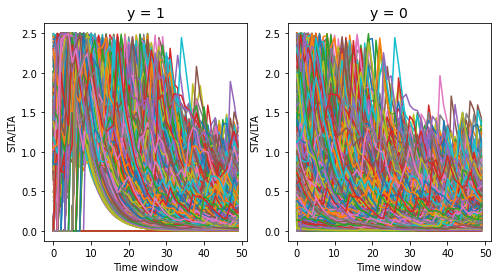

In [16]:
# generate input data X using the strategy of Wang & Teng (1995)
n = len(EQ_list)

#YOUR CODE HERE
#size_input = ?
#dt = ?


#SOLUTION
size_input = 50
dt = 60


X1 = np.empty(shape = (n, size_input))
X0 = np.empty(shape = (n, size_input))
for i in range(n):
    evi = EQ_list[i]
    dtfl = h5py.File(file_name, 'r')
    dataset = dtfl.get('data/' + str(evi)) 
    data = np.array(dataset)
    
    #YOUR CODE HERE (=1 line of code)
    #STALTA = ?
    
    
    #SOLUTION
    STALTA = recursive_sta_lta_py(data[::dt,0], 2 * sampling_rate / dt, 5 * sampling_rate / dt)
    
    
    ind_onset = dataset.attrs['p_arrival_sample'] / dt
    ind_onset = ind_onset.astype(int)
    
    #YOUR CODE HERE
    #X1[i, :] = ?
    #u = ?
    #X0[i, :] = ?
    
    
    #SOLUTION
    X1[i, :] = STALTA[ind_onset-3:ind_onset+47]
    u = np.random.randint(30)
    X0[i, :] = STALTA[ind_onset+u:ind_onset+u+50]


# plot X input for class 1 (earthquake onset at t=t0+20) and class 0 (no earthquake onset)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
[axs[0].plot(X1[i,:]) for i in range(n)]
axs[0].set_xlabel('Time window')
axs[0].set_ylabel('STA/LTA')
axs[0].set_title('y = 1', size=14)

[axs[1].plot(X0[i,:]) for i in range(n)]
axs[1].set_xlabel('Time window')
axs[1].set_ylabel('STA/LTA')
axs[1].set_title('y = 0', size=14);

Let us only look at 10 time series for each class:

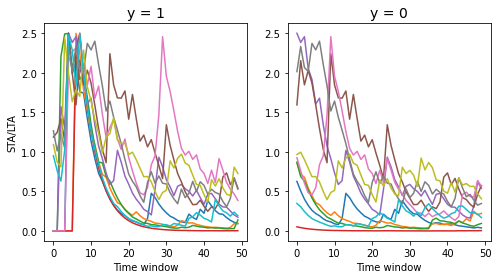

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
[axs[0].plot(X1[i,:]) for i in range(10)]

axs[0].set_xlabel('Time window')
axs[0].set_ylabel('STA/LTA')
axs[0].set_title('y = 1', size=14)

[axs[1].plot(X0[i,:]) for i in range(10)]
axs[1].set_xlabel('Time window')
axs[1].set_title('y = 0', size=14);

**EXERCISE 6:** We now have our input $X$. Define the matching $y$ labels 1 and 0 by using `np.ones` and `np.zeros`. Then, define `X_train`, `X_test`, `y_train` and `y_test` with 20% data in the test set.

In [18]:
X = np.concatenate([X1, X0], axis=0)

#YOUR CODE HERE


#SOLUTION
y = np.concatenate([np.ones(n), np.zeros(n)], axis=0).reshape(2*n, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

**EXERCISE 7:** Define, compile and train an ANN model with the same architecture as defined in the 1995 article. You have flexibility in which activation functions to use. Use accuracy as performance metric.

In [19]:
import tensorflow as tf
tf.__version__

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [24]:
#YOUR CODE HERE
#size_hidden = ?
#model_ANN = ?
#model_ANN.compile(...)


#SOLUTION
size_hidden = 8

model_ANN = Sequential([
    Dense(size_hidden, activation = 'relu', input_shape = (size_input, )),
    Dense(1, activation = 'sigmoid')
])

model_ANN.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

Evaluating on training set...
loss = 0.0824, accuracy = 96.8990%
Evaluating on testing set...
loss = 0.0738, accuracy = 97.4781%


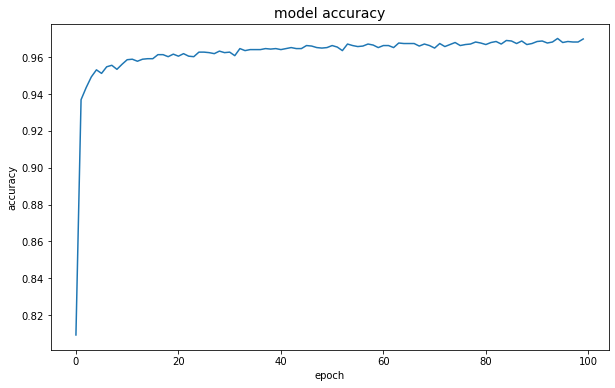

In [25]:
#YOUR CODE HERE
#results_ANN = model_ANN.fit(...)


#SOLUTION
results_ANN = model_ANN.fit(
    X_train, y_train,
    epochs = 100,
    validation_data = (X_test, y_test),
    verbose = 0   # 0 to hide the training progress, 1 otherwise
)


# summarize training history
plt.plot(results_ANN.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('model accuracy', size=14);

print("Evaluating on training set...")
(loss, accuracy) = model_ANN.evaluate(X_train, y_train, verbose = 0)
print("loss = {:.4f}, accuracy = {:.4f}%".format(loss, accuracy * 100))

print("Evaluating on testing set...")
(loss, accuracy) = model_ANN.evaluate(X_test, y_test, verbose = 0)
print("loss = {:.4f}, accuracy = {:.4f}%".format(loss, accuracy * 100))

Let us explore the probability of earthquake onset as we move along a STA-LTA time series:

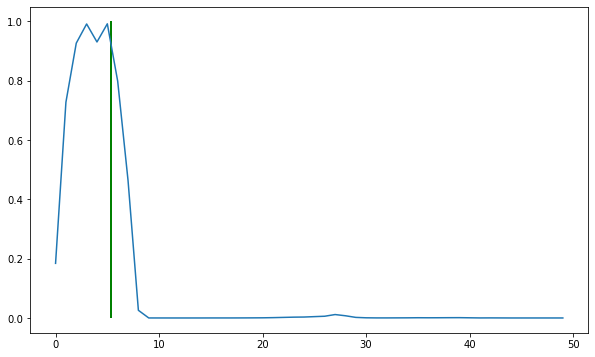

In [26]:
evi = EQ_list[0]
dtfl = h5py.File(file_name, 'r')
dataset = dtfl.get('data/' + str(evi)) 
data = np.array(dataset)
STALTA = recursive_sta_lta_py(data[::dt,0], 2 * sampling_rate / dt, 5 * sampling_rate / dt)

Pr_Parrival = np.empty(shape = (50, 1))
for i in range(50):
    X_newtest = STALTA[i:i+50].reshape(1,50)
    Pr_Parrival[i] = model_ANN.predict(X_newtest)

plt.plot(Pr_Parrival)
plt.vlines(dataset.attrs['p_arrival_sample'] / dt - 3, 0, 1, color='g', linewidth=2);

**EXERCISE 8:** Compare the ANN model accuracy to the one obtained with the STA/LTA baseline model. Which one is better? How can you explain the differences observed with the results of Wang & Teng (1995)? See their table below:

<img src="figs_notebook/ref_wang&Teng_tab.png" width = 500>

In [27]:
#YOUR CODE HERE (several lines of code)



#SOLUTION
n = len(X_test)

y_pred_STALTA = np.zeros(shape = (n, 1))
for i in range(n):
    ind = np.argwhere(X_test[i,:] > threshold)
    if len(ind) != 0:
        y_pred_STALTA[i, 0] = 1
        
print("Accuracy (training data): {} %".format(100 - np.mean(np.abs(y_pred_STALTA - y_test)) * 100))

Accuracy (training data): 80.92105263157895 %


_YOUR ANSWER HERE_

### 3.2. Power spectrum frequencies as input nodes (Dowla et al., 1990)

Let us now have a look at a different example of binary classification between noise waveform and earthquake waveform. We will follow the approach developed by Dowla et al. (1990) to discriminate between earthquakes and explosions. In this case, the frequencies of the seismic waveform spectrum are used as input nodes (instead of a STA/LTA time series used in the previous section).

<img src="figs_notebook/ref_Dowla_etal1990.png" width = 700>

In signal processing, a _periodogram_ is an estimate of the spectral density of a signal. It can be computed using `periodogram` from `scipy.signal`. It means that we will work in spectral space insted of temporal space.

In [28]:
# waveform spectrum
from scipy.signal import periodogram
from scipy.interpolate import interp1d

**EXERCISE 9:** The authors wrote: "_The input layer is represented by a vector corresponding to the (M = 41) frequency components for each of the three phases, sampled logarithmically from 0.1 to 10 Hz._" Define the vector `freqi` using `np.logspace(xmin_log10, xmax_log10, num = number_increments)`.

In [29]:
# YOUR CODE HERE



# SOLUTION
# frequency-domain input nodes
size_input = 41 # Dowla et al. (1990)
minf = .1
maxf = 10
freqi = np.logspace(np.log10(minf), np.log10(maxf), num = size_input)
freqi

array([ 0.1       ,  0.11220185,  0.12589254,  0.14125375,  0.15848932,
        0.17782794,  0.19952623,  0.22387211,  0.25118864,  0.28183829,
        0.31622777,  0.35481339,  0.39810717,  0.44668359,  0.50118723,
        0.56234133,  0.63095734,  0.70794578,  0.79432823,  0.89125094,
        1.        ,  1.12201845,  1.25892541,  1.41253754,  1.58489319,
        1.77827941,  1.99526231,  2.23872114,  2.51188643,  2.81838293,
        3.16227766,  3.54813389,  3.98107171,  4.46683592,  5.01187234,
        5.62341325,  6.30957344,  7.07945784,  7.94328235,  8.91250938,
       10.        ])

**EXERCISE 10:** Calculate the spectral density of an earthquake signal and of a noise signal taken from STEAD (only consider the first channel, EW). This is done as follows: `freq, power_spectrum_dens = periodogram(time_series, sampling_rate)`. 

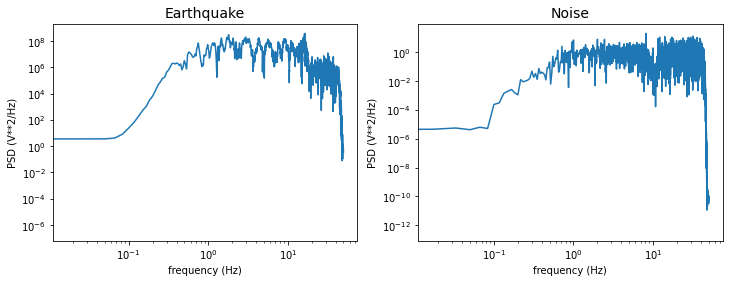

In [30]:
# YOUR CODE HERE

# retrieve data
# use h5py.File...
#data_EQ = ?
#data_noise = ?

# get freq and power_spectrum_dens from periodogram for both earthquake and noise

# plot
#fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# ...



# SOLUTION
# retrieving selected waveforms from the hdf5 file: 
dtfl = h5py.File(file_name, 'r')
data_EQ = np.array(dtfl.get('data/' + str(EQ_list[0])))
data_noise = np.array(dtfl.get('data/' + str(noise_list[0])))

# waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
freq1, power_spectrum_dens1 = periodogram(data_EQ[:,0], sampling_rate)
freq2, power_spectrum_dens2 = periodogram(data_noise[:,0], sampling_rate)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(freq1, power_spectrum_dens1)
axs[0].set_xscale('log')
axs[0].set_xlabel('frequency (Hz)')
axs[0].set_ylabel('PSD (V**2/Hz)')
axs[0].set_title('Earthquake', size=14)

axs[1].semilogy(freq2, power_spectrum_dens2)
axs[1].set_xscale('log')
axs[1].set_xlabel('frequency (Hz)')
axs[1].set_ylabel('PSD (V**2/Hz)')
axs[1].set_title('Noise', size=14);

**EXERCISE 11:** We imported the function `interp1d` above. Can you guess the reason why, based on the problem setup of Dowla et al. (1990)? Use the interpolation technique as follows: First define `func = interp1d(x, y)`, then determine `yi = func(xi)`. Plot your result on top of the two periodograms.

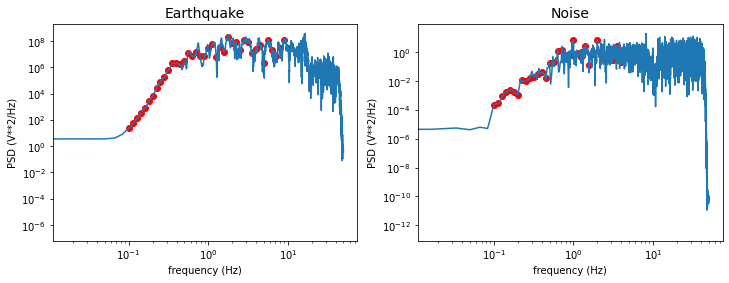

In [31]:
# YOUR CODE HERE



# SOLUTION

# way to select freqi directly??
f = interp1d(freq1, power_spectrum_dens1)
power_spectrum_dens1i = f(freqi)
f = interp1d(freq2, power_spectrum_dens2)
power_spectrum_dens2i = f(freqi)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(freq1, power_spectrum_dens1)
axs[0].scatter(freqi, power_spectrum_dens1i, color = 'red')
axs[0].set_xscale('log')
axs[0].set_xlabel('frequency (Hz)')
axs[0].set_ylabel('PSD (V**2/Hz)')
axs[0].set_title('Earthquake', size=14)

axs[1].semilogy(freq2, power_spectrum_dens2)
axs[1].scatter(freqi, power_spectrum_dens2i, color = 'red')
axs[1].set_xscale('log')
axs[1].set_xlabel('frequency (Hz)')
axs[1].set_ylabel('PSD (V**2/Hz)')
axs[1].set_title('Noise', size=14);

**EXERCISE 12:** What you just defined are the features of the ANN. Do it systematically for the data in STEAD. First make sure to use a balanced dataset which will be constrained by the class with the smaller number of instances $n$. Second, loop on $n$ to define the features `X1` for all earthquake samples and `X0` for all noise samples.

In [32]:
[len(EQ_list), len(noise_list)]

[2278, 200]

In [33]:
# YOUR CODE HERE




# SOLUTION
n_EQ = len(EQ_list)
n_noise = len(noise_list)
n = n_noise  # balanced data

X1 = np.empty(shape = (n, size_input))
X0 = np.empty(shape = (n, size_input))
for i in range(n):
    ## earthquake y = 1 ##
    evi = EQ_list[i]
    dtfl = h5py.File(file_name, 'r')
    data_EQ = np.array(dtfl.get('data/' + str(EQ_list[i])))
    data_noise = np.array(dtfl.get('data/' + str(noise_list[i])))
    
    freq1, power_spectrum_dens1 = periodogram(data_EQ[:,0], sampling_rate)
    freq2, power_spectrum_dens2 = periodogram(data_noise[:,0], sampling_rate)

    f = interp1d(freq1, power_spectrum_dens1)
    X1[i,:] = f(freqi)
    f = interp1d(freq2, power_spectrum_dens2)
    X0[i,:] = f(freqi)

**EXERCISE 13:** Similarly to exercise 6, concatenate all data into `X` and `y` (1 for earthquake, 0 for noise). Then do a train/test split with 20% of the data in the test set.

In [34]:
# YOUR CODE HERE



# SOLUTION
X = np.concatenate([X1, X0], axis=0)
y = np.concatenate([np.ones(n), np.zeros(n)], axis=0).reshape(2*n, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

**EXERCISE 14:** Define an ANN with the architecture of your choice, plot the training history, and finally evaluate the accuracy of your model on your test set. Dowla et al. (1990) originally obtained ACC > 93%.

Evaluating on training set...
loss = 0.0325, accuracy = 99.0625%
Evaluating on testing set...
loss = 1470.2809, accuracy = 97.5000%


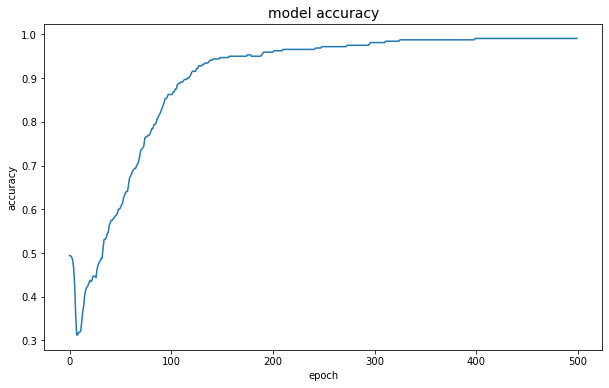

In [39]:
# YOUR CODE HERE



# SOLUTION
# ANN model
size_hidden = 20

model_ANN = Sequential([
    Dense(size_hidden, activation = 'relu', input_shape = (size_input, )),
    Dense(1, activation = 'sigmoid')
])

model_ANN.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

results_ANN = model_ANN.fit(
    X_train, y_train,
    epochs = 500,
    validation_data = (X_test, y_test),
    verbose = 0   # 0 to hide the training progress, 1 otherwise
)

# summarize training history
plt.plot(results_ANN.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('model accuracy', size=14);

print("Evaluating on training set...")
(loss, accuracy) = model_ANN.evaluate(X_train, y_train, verbose = 0)
print("loss = {:.4f}, accuracy = {:.4f}%".format(loss, accuracy * 100))

print("Evaluating on testing set...")
(loss, accuracy) = model_ANN.evaluate(X_test, y_test, verbose = 0)
print("loss = {:.4f}, accuracy = {:.4f}%".format(loss, accuracy * 100))

**EXERCISE 15:** Did you notice the peculiarity of the Dowla et al. (1990) "ANN"? What did they actually use?

_YOUR ANSWER HERE_


SOLUTION

They used one neuron only in the hidden layer, i.e. a logistic regression

## References

* Allen (1982), Automatic phase pickers: Their present use and future prospects, Bull. Seismol. Soc. Am., 72 (6), S225-S242
* Dowla et al. (1990), Seismic discrimination with artificial neural networks: Preliminary results with regionsl spectral data, Bull. Seismol. Soc. Am., 80 (5), 1346-1373
* Mousavi et al. (2019), STanford EArthquake Dataset (STEAD): A Global Data Set of Seismic Signals for AI, IEEE Access, 7, 179464-179476
* STanford EArthquake Dataset (STEAD): A Global Data Set of Seismic Signals for AI, available at https://github.com/smousavi05/STEAD
* Wang & Teng (1995), Artificial Neural Network-Based Seismic Detector, Bull. Seismol. Soc. Am., 85 (1), 308-319